In [3]:
# %%capture
# !pip install langgraph langchain langchain_openai langchain_community

In [1]:
# Import
import os
import sys

# Change to the project root directory
os.chdir('/home/alaa/repos/seez-assignment')
current_dir = os.getcwd()
if current_dir not in sys.path:
    sys.path.insert(0, current_dir)

try:
    from src.utils.tools import read_dialogue
    print("Import successful!")
except:
    print("Failed")

import os

from src.api_key import OPENAI_API_KEY

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

Import successful!


In [2]:
from typing import Annotated, Dict
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    completed_nodes: Annotated[list[str], lambda x, y: list(set(x + y))]
    active_nodes: Annotated[list[str], lambda x, y: y]
    latest_router_decision: str
    user_context: Dict = {}
    similarities: Dict = {}

In [3]:
from typing import List, Callable, Dict, Any

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig

model_name = "gpt-4o"

class AssistantNode:
    def __init__(
            self, 
            name: str, system_prompt: str, 
            tools: List[Callable] = [], 
            completion_tool: str = "", 
            llm_chain: Runnable = None,
            model_name=model_name
            ) -> None:
        """
        completion_tool: Is the tool binded to the node and once it is triggered, this
        node is assigned as completed, and this node name 'name' is appended to the State
        completed_node variable.
        """
        self.name = name
        self.system_prompt = system_prompt
        self.tools = tools
        self.completion_tool = completion_tool
        self.llm = llm_chain or ChatOpenAI(model=model_name)

    def update_system_prompt(self, prompt_config: dict) -> str:
        # self.logger.debug(f"Updating system prompt for {self.name}...")
        print(f"Updating system prompt for {self.name}...")
        try:
            if prompt_config and isinstance(prompt_config, dict):
                formatted_prompt = self.system_prompt.format_map(prompt_config)
                # self.logger.info(f"Using prompt config for {self.name}")
                print(f"Using prompt config for {self.name}")
            else:
                formatted_prompt = self.system_prompt
                # self.logger.info(f"Using default prompt for {self.name},no prompt configs!")
                print(f"Using default prompt for {self.name},no prompt configs!")
        except KeyError as e:
            formatted_prompt = self.system_prompt
            print(f"Error formatting prompt for {self.name}: {e}")
            # self.logger.error(f"Error formatting prompt for {self.name}: {e}")
        return formatted_prompt

    def _is_completed(self, state: Dict[str, Any]) -> bool:
        messages = state.get("messages", [])

        special_tool_index = None
        for i, message in enumerate(reversed(messages)):
            if isinstance(message, ToolMessage) and message.name == self.completion_tool:
                return True
        return False

    async def __call__(self, state: State, config: RunnableConfig) -> Dict[str, Any]:

        print(f"Current Node: {self.name.title()}\n")

        system_prompt = self.update_system_prompt(
            {**state["user_context"]["user_data"]}
        )
        assistant_prompt = ChatPromptTemplate.from_messages([("system", system_prompt),("placeholder", "{messages}")])
        if self.tools:
            llm_chain = assistant_prompt | self.llm.bind_tools(self.tools)
        else:
            llm_chain = assistant_prompt | self.llm

        while True:
            response = await llm_chain.ainvoke(state)
            # print(response)
            if not response.tool_calls and (
                not response.content
                or isinstance(response.content, list)
                and not response.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Your last response was empty. Please provide a correct response.")]
                state = {**state, "messages": messages}
            else:
                break

        if self._is_completed({**state, "messages": state["messages"] + [response]}):
            active_nodes = list(set(state["active_nodes"]) - {self.name})
            return {"messages": response, "completed_nodes": [self.name], "active_nodes": active_nodes}

        active_nodes = list(set(set(state["active_nodes"]) | {self.name}))
        return {"messages": response, "active_nodes": [self.name]}

In [4]:
# class FollowUpNode(AssistantNode):
#     def __init__(self, **kwargs):
#         super().__init__(**kwargs)

#     def __call__(self, state: Dict[str, Any], config: Dict[str, Any]) -> Dict[str, Any]:
#         return {"active_nodes": [self.name], **super().__call__(state, config)}

In [4]:
# from typing import Dict, List, Any, Optional, Union, Tuple
# from langchain_core.runnables import RunnableConfig
# from langchain_core.messages import HumanMessage, SystemMessage, AnyMessage, AIMessage, ToolMessage
# from langchain_core.messages.tool import ToolCall

# from langchain_openai import ChatOpenAI

# from pydantic import BaseModel, Field

# class RouterResponse(BaseModel):
#     agent_name: str = Field(description="Name of the specialized agent best suited to handle the user's current request.")
#     request: str = Field(description="Concise summary of user's request and relevant context that helps the selected agent understand and address the need effectively.")

# class Router:
#     def __init__(
#         self,
#         nodes: Union[List[str], Dict[str, str]], 
#         system_prompt: str,
#         llm: Optional[ChatOpenAI] = None,
#         model: str = "",
#         default_node: Optional[str] = None,
#         max_preview: int = 100,
#         max_history: int = 10,
#         k_latest_messages: int = 6,
#         max_assistant_preview: int = 20,
#         default_tool_response: str = "Tool successfully executed",
#         default_model: str = "gpt-4o"
#     ) -> None:
#         """
#         Initialize Router node.
        
#         Args:
#             nodes: List of node names or Dict of node names to descriptions
#             llm: Language model instance (optional)
#             model: Model name (optional)
#             system_prompt: System prompt for the router (optional)
#             default_node: Default node to route to (optional)
#         """
#         self.model = model if "gpt-4o" in model else default_model
#         self.llm = llm or ChatOpenAI(model=self.model).with_structured_output(RouterResponse)
#         self.nodes = nodes
#         self.default_node = default_node or self._get_default_node()
#         self.system_prompt = system_prompt
#         self.max_preview = max_preview
#         self.max_history = max_history
#         self.k_latest_messages = k_latest_messages
#         self.max_assistant_preview = max_assistant_preview
#         self.default_tool_response = default_tool_response or "Tool successfully executed"

#     def _get_default_node(self) -> str:
#         """Get default node from nodes configuration."""
#         return (
#             self.nodes[0] if isinstance(self.nodes, list) 
#             else list(self.nodes.keys())[0]
#         )

#     def _format_message(self, message: AnyMessage) -> Optional[str]:
#         """Format a single message for history."""
#         if isinstance(message, HumanMessage):
#             return f"User: {message.content}"
#         elif isinstance(message, AIMessage) and message.content:
#             preview = message.content[:self.max_preview] + "...(preview)"
#             return f"Assistant: {preview}"
#         return None

#     def _prepare_message_history(self, messages: List[AnyMessage]) -> str:
#         """Prepare message history for router context."""
#         formatted_messages = [
#             msg for msg in (self._format_message(m) for m in messages)
#             if msg is not None
#         ]
#         return "\n".join(formatted_messages)

#     def _get_nodes_description(self, state: State) -> Tuple[List[str], str]:
#         """Get available nodes and their description."""
#         completed_nodes = state.get("completed_nodes", [])

#         if isinstance(self.nodes, list):
#             available_nodes = [
#                 node for node in self.nodes 
#                 if node not in completed_nodes
#             ]
#             nodes_description = ", ".join(available_nodes)
#         else:
#             available_nodes = {
#                 node: desc 
#                 for node, desc in self.nodes.items() 
#                 if node not in completed_nodes
#             }
#             nodes_description = "\n".join(
#                 f"- {node}: {desc}" 
#                 for node, desc in available_nodes.items()
#             )
#             available_nodes = list(available_nodes.keys())

#         return available_nodes, nodes_description

#     def _create_router_messages(self, 
#                               state: State, 
#                               nodes_description: str) -> List[Union[SystemMessage, HumanMessage]]:
#         """Create messages for router LLM."""
#         system_prompt = (
#             f"{self.system_prompt}\n\n"
#             f"Available agents:\n{nodes_description}\n\n"
#             "Output should be with two keys: "
#             "'agent_name' (the name of the best-suited agent) and 'request' (a concise summary of the user's request)."
#         )
#         latest_messages = self._prepare_message_history(state.get("messages", []))
#         user_msg = f"Chat History:\n{latest_messages}\n\nAgents Name:"
        
#         return [
#             SystemMessage(content=system_prompt),
#             HumanMessage(content=user_msg)
#         ]

#     def _add_router_tool(self, router_response: RouterResponse) -> Dict[str, Any]:
#         """Add route tool to state."""
#         routing_message = (
#             f"The assistant is now the {router_response.agent_name}. "
#             "Reflect on the above conversation between the host assistant and the user. "
#             "Do not mention who you are - just act as the proxy for the assistant."
#             )
#         messages = [
#             AIMessage(content="", tool_calls=[ToolCall(name="Router", args={"agent_name": router_response.agent_name, "request": router_response.request}, id="")]),
#             ToolMessage(content=routing_message, name="Router", tool_call_id=""),
#             ]
#         return messages

#     def __call__(self, state: State, config: RunnableConfig) -> Dict[str, Any]:
#         """Route to appropriate node based on conversation state."""
#         print("\nCurrent Node: Router")
        
#         available_nodes, nodes_description = self._get_nodes_description(state)
        
#         if not available_nodes:
#             print(f"Router selected default node: {self.default_node}")
#             return {"latest_router_decision": self.default_node}

#         messages = self._create_router_messages(state, nodes_description)
        
#         while True:
#             # try:
#             response = self.llm.invoke(messages)
#             print("Response: ", response)
#             node_name = response.agent_name
            
#             if node_name and node_name in available_nodes:
#                 break
                
#             messages.append(
#                 HumanMessage(
#                     content="Not a valid node! Please try again. "
#                     f"Your output should be an agent name from the available agents {available_nodes}."
#                 )
#             )
#             # except Exception as e:
#             #     print(f"Error in router: {e}")
#             #     node_name = self.default_node

#         print(f"Router selected: {node_name}")
        
#         messages = self._add_router_tool(response)
#         return {"messages": messages,  "latest_router_decision": node_name}

In [5]:
import random

def fetch_user_information(
    state, 
    config
):
    print(); print("Current Node: Fetch User Info")
    configuration = config.get("configurable", {})
    user_id = configuration.get("user_id", None)

    user_data = {}
    
    if not user_id:
        return {
            "user_context": {
                "user_data": user_data, 
                "user_exists": False,
            },
            "similarities": {}
        }
    
    try:
        from src.utils.tools import read_dialogue, read_user_data, read_jsonl, read_json, get_conversation_by_id

        path = 'data/Movie'
        final_data_path = '{}/final_data.jsonl'.format(path)
        Conversation_path = '{}/Conversation.txt'.format(path)
        user_map_path = '{}/user_ids.json'.format(path)
        item_map_path = '{}/item_map.json'.format(path)
        
        final_data = read_jsonl(final_data_path)
        item_map = read_json(item_map_path)
        user_map = read_json(user_map_path)
        Conversation = read_dialogue(Conversation_path)

        if user_id in user_map:
            user_information = read_user_data(final_data_path, user_id)
            history_interaction = user_information['history_interaction']
            user_might_likes = user_information['user_might_like']
        
            user_data = {
                    "history_interaction": [item_map[history_interaction[k]] for k in range(len(history_interaction))],
                    "user_might_like": [item_map[user_might_likes[k]] for k in range(len(user_might_likes))],
                    "conversations": ""
                }
            Conversation_info = user_information['Conversation']
            for j in range(len(Conversation_info)):
                per_conversation_info = Conversation_info[j]['conversation_{}'.format(j + 1)]
                user_likes_id = per_conversation_info['user_likes']
                user_dislikes_id = per_conversation_info['user_dislikes']
                rec_item_id = per_conversation_info['rec_item']
                conversation_id = per_conversation_info['conversation_id']
                dialogue = get_conversation_by_id(Conversation, conversation_id)
                user_data['conversations'] += "==================================\n\n" + dialogue
        
            return {
                "user_context": {
                    "user_data": user_data, 
                    "user_exists": True,
                },
                "similarities": {}
            }

        return {
            "user_context": {
                "user_data": user_data, 
                "user_exists": False,
            },
            "similarities": {}
        }

    except Exception as e:
        print(e)
        return {
            "user_context": {
                "user_data": user_data, 
                "user_exists": False,
            },
            "similarities": {}
        }

In [6]:
from datetime import datetime

def init_session_state(
    state,
    config
):
    print(); print("Current Node: Init Session State")

    return {
        "completed_nodes": [],
        "active_nodes": [],
        "latest_router_decision": "",
        "session_data": {
            "date": datetime.now().strftime("%A, %B %d, %Y"),
            "time": datetime.now().strftime("%H:%M:%S")
        },
        "user_context": {
            "user_data": {}, 
            "user_exists": False,
        },
        "similarities": {}
    }

In [7]:
import uuid

state = State()
config = config = {
        "configurable": {
            "thread_id": str(uuid.uuid4()),
            "user_id": "A30Q8X8B1S3GGT"
        }
    }

state_ = fetch_user_information(state, config)

In [8]:
import pandas as pd
from typing import List, Union
from langchain_core.tools import tool

from src.infrastructure.search_engine.faiss import FAISS_Search

@tool
def get_recommendations(collected_info: str) -> list[dict]:
    """
    Get movie recommendations based on collected user preferences.
    
    Args:
        collected_info (str): Concise summary of user preferences from follow-up agent
            Example: "User is looking for intense psychological thrillers like Inception and Shutter Island, prefer modern movies with complex plots"
    
    Returns:
        list[str]: List of recommended movies
    """
    template = """<provided_context>\n: {conversations}"""
    try: 
        similarity_search = FAISS_Search()
        results = similarity_search.search(collected_info)
    
        if not results.response:
            return "No recommendations found."
            
        formatted_results = []
        
        for i, (doc, score) in enumerate(results.response, 1):
            recommendation = (
                f"{'-' * 40}\n"
                f"{doc.page_content.strip()}\n"
                f"{'-' * 40}"
            )
            formatted_results.append(recommendation)
        
        separator = "\n\n" + "=" * 80 + "\n\n"
        return template.format_map({"conversations": separator.join(formatted_results)})
        
    except Exception as e:
        return f"Failed to get similar movies: {e}"
    return f"Failed to get similar movies"

In [9]:
# graph.get_state(config)

In [10]:
recommender_old_prompt = (
    "You are a movie recommendation assistant. Your role is to recommend movies to the user, from user's preferences in the <provided_context>. \n"
    "Do recommendations only from the preference in <provided_context>. NEVER invent or suggest movies not in the <provided_context>. \n"
    "If the user is unsatisfied with all available recommendations, trigger the `get_recommendations` tool to get more suggestions. \n"
    "Without directly mentioning that you are relying on the context, analyze it to infer the user's likes and dislikes. \n"
    "Suggest movies one-by-one, avoiding films they have expressed negative opinions about or already discussed. \n"
    "Briefly explain the recommendations naturally and conversationally. \n"
    """<provided_context>  
    - **User Preferences (Movies for main recommendation):** `{user_might_like}`  
    - **Conversation History (Only to mirror the response style):** `{conversations}`  
    </provided_context>\n"""
)

recommender_new_prompt = (
    "You are a movie recommendation assistant. Your role is to recommend movies to the user, from user's preferences in the <provided_context>. \n"
    "Do recommendations only from the preference in <provided_context>. NEVER invent or suggest movies not in the <provided_context>. \n"
    "Without directly mentioning that you are relying on the context, analyze it to infer the user's likes and dislikes. \n"
    "Suggest movies one-by-one, avoiding films they have expressed negative opinions about or already discussed. \n"
    "Briefly explain the recommendations naturally and conversationally. \n"
)

follow_up_prompt = (
    "You are a focused follow-up agent in a movie recommendation system. \n"
    "Your task is to gather essential preferences when the user's query lacks detail, then trigger the recommendation tool with a concise summary. \n"
    """Key Guidelines:
Do not make recommendations yourself.
Confirm receiving relevant recommendations after triggering the tool—another agent handles the suggestions.
Collect only the following information, in this order of priority:
Favorite movies or genres.
Mood or tone preferences.
Time period preferences (only if relevant).

Process:

If input is sufficient, trigger the tool immediately—no further questions.
Summarize user preferences concisely for the tool.
Stop collecting once enough information is gathered.
"""
)

# router_prompt = """
# You are a conversation router for a movie recommendation system. Your task is to analyze user conversation and determine whether they contain sufficient information for making recommendations or require follow-up questions to clarify preferences. Assign only ONE assistant per message; do NOT delegate multiple assistants.

# Decision Criteria:
# Route to `recommender` if query has:
# - Specific movie references (e.g., "like Star Wars")
# - Clear genre preferences (e.g., "action movies")
# - Explicit attributes (e.g., "80s comedies")
# - Actor/Director preferences (e.g., "movies with Tom Hanks")
# - Mood/Theme specifications (e.g., "something suspenseful")

# Route to follow_up if query:
# - Is too general (e.g., "recommend a movie")
# - Contains ambiguous terms
# - Needs preference clarification
# - Has multiple possible interpretations

# """
# Recommender Agent for old users
recommender_old_tools = [get_recommendations]
recommender_old_node = AssistantNode(
    name="recommender_old", 
    system_prompt=recommender_old_prompt, 
    tools=recommender_old_tools
)

# Recommender Agent for new users
recommender_new_node = AssistantNode(
    name="recommender_new", 
    system_prompt=recommender_new_prompt, 
)

# Follow-up Agent
follow_up_tools = [get_recommendations]
follow_up_node = AssistantNode(
    name="follow_up", 
    system_prompt=follow_up_prompt, 
    tools=follow_up_tools,
    completion_tool=get_recommendations.func.__name__
)

# # Router
# router_node = Router(
#     system_prompt=router_prompt, 
#     nodes = ["follow_up", "recommender"],
#     default_node="recommender"

# )

In [11]:
from langchain_core.runnables import RunnableLambda
from langgraph.prebuilt import ToolNode

def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], 
        exception_key="error"
    )

In [12]:
from langgraph.graph import END
from langgraph.prebuilt import tools_condition

# Routing Functions
def start_decision(state: State):
    route = tools_condition(state)    
    tool_msgs = [tool.name for tool in [msg for msg in state["messages"] if msg.type == "tool"]]

    if len(state["messages"]) == 1:
        return "init_session_state"
    
    elif not state["user_context"]["user_exists"]:
        if follow_up_node.completion_tool in tool_msgs: #and "follow_up" in state["active_nodes"]
            return "recommender_new"
        else:
            return "follow_up"
    return "recommender_old"

def fetch_user_info_decision(state):
    if state["user_context"]["user_exists"]:
        return "recommender_old"
    return "follow_up" #"router"

# def router_decision(state: State):
#     route = tools_condition(state)    
#     tool_msgs = [tool.name for tool in [msg for msg in state["messages"] if msg.type == "tool"]]
#     if state["latest_router_decision"] == "follow_up":
#         return "follow_up"
#     elif state["user_context"]["user_exists"]:
#         return "recommender_old"
#     return "recommender_new"

def recommender_old_decision(state: State):
    route = tools_condition(state)
    if route == END:
        return END
    return "recommender_tools"

def follow_up_decision(state: State):
    route = tools_condition(state)    
    tool_msgs = [tool.name for tool in [msg for msg in state["messages"] if msg.type == "tool"]]
    if route == END:
        if state["user_context"]["user_exists"] or follow_up_node.completion_tool in tool_msgs:
            return "recommender_new"            
        else: 
            return END
    return "follow_up_tools"

In [13]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(State)

# Add nodes
workflow.add_node("init_session_state", init_session_state)
workflow.add_node("fetch_user_information", fetch_user_information)


# workflow.add_node("router", router_node)

workflow.add_node("follow_up", follow_up_node)
workflow.add_node("follow_up_tools", create_tool_node_with_fallback(follow_up_tools))

workflow.add_node("recommender_old", recommender_old_node)
workflow.add_node("recommender_new", recommender_new_node)
workflow.add_node("recommender_tools", create_tool_node_with_fallback(recommender_old_tools))

# Add edges 
workflow.add_conditional_edges(
    START, 
    start_decision, 
    ["init_session_state", "follow_up", "recommender_old", "recommender_new"], #"router", ]
)

workflow.add_edge("init_session_state", "fetch_user_information")
workflow.add_conditional_edges(
    "fetch_user_information",
    fetch_user_info_decision,
    ["recommender_old", "follow_up"] #, "router"])
)

# workflow.add_conditional_edges(
#     "router",
#     router_decision,
#     ["follow_up", "recommender_old", "recommender_new"],
# )

workflow.add_edge("recommender_tools", "recommender_old")
workflow.add_conditional_edges(
    "recommender_old", 
    recommender_old_decision, 
    ["recommender_tools", END]
)
workflow.add_edge("recommender_new", END)

workflow.add_edge("follow_up_tools", "follow_up")
workflow.add_conditional_edges(
    "follow_up",
    follow_up_decision, 
    ["recommender_new", "follow_up_tools", END]
)

# Compile the graph
checkpointer = MemorySaver()
graph = workflow.compile(checkpointer=checkpointer)

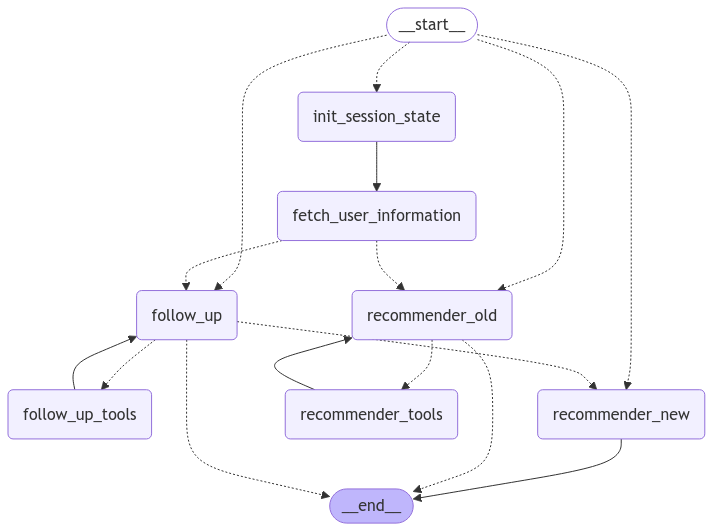

In [14]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [15]:
def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [23]:
# import shutil
import uuid

thread_id = str(uuid.uuid4())
old_user_id = "A30Q8X8B1S3GGT"
new_user_id = "123"

config = {
    "configurable": {
        "thread_id": thread_id,
        "user_id": new_user_id
    }
}

_printed = set()
while True:
    question = input()
    events = graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)

/usr/lib/python3.10/ast.py:50: RuntimeWarning: coroutine 'chat_loop' was never awaited
  return compile(source, filename, mode, flags,


KeyboardInterrupt: Interrupted by user

In [20]:
events

<coroutine object get_response at 0x7f81f9965e70>

In [1]:
# import shutil
import uuid

thread_id = str(uuid.uuid4())
old_user_id = "A30Q8X8B1S3GGT"
new_user_id = "123"

config = {
    "configurable": {
        "thread_id": thread_id,
        "user_id": new_user_id
    }
}

_printed = set()
while True:
    question = input()
    events = graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)

KeyboardInterrupt: Interrupted by user

In [2]:
graph.get_state(config).values

NameError: name 'graph' is not defined

In [92]:
from src.utils.fetch_data import get_user_data

print(get_user_data("A30Q8X8B1S3GGT"))

{'user_id': {'history_interaction': ['No Highway In The Sky VHS', 'Outland VHS', 'The Black Raven', 'La Bella y La Bestia Beauty and the Beast  VHS', 'White Christmas', 'Silk Stockings VHS', 'Captain Scarlet and the Mysterons', 'Andersonville Trial VHS', 'The Tuxedo', 'Lonely Wives', 'Alice in Wonderland Walt Disney Masterpiece Collection  VHS', 'White Christmas VHS', 'Three Kings', 'National Security', 'Day of the Triffids VHS', 'Monsters, Inc.', 'In Like Flint VHS', 'The Screaming Skull/Werewolf Vs Vampire', 'Hangmen'], 'user_might_like': ['Never a Dull Moment [VHS]', "Pirates of the Golden Age Movie Collection: (Against All Flags / Buccaneer's Girl / Yankee Buccaneer / Double Crossbones)"], 'Conversation': {'conversation_1': {'user_likes': ['White Christmas'], 'user_dislikes': [], 'rec_item': ['Never a Dull Moment [VHS]'], 'conversation_id': 0, 'dialogue': 'User: Hi, I\'m Mark Savary. I really enjoyed watching "White Christmas". It\'s a semi-remake of "Holiday Inn" and features Bing